## **사전 학습된(Pre-trained) ResNet 사용해보기**

In [1]:
# PyTorch 라이브러리 불러오기
import torch
# 신경망은 torch.nn 패키지를 사용하여 생성
import torch.nn as nn
# 다양한 이미지 변환 기능들을 제공
import torchvision.transforms as transforms

In [2]:
# 파이토치 GPU 장치 사용 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### **이미지넷(ImageNet)에 정의된 클래스 정보 가져오기**

In [3]:
# URL을 열기 위한 확장 가능한 라이브러리
from urllib.request import urlretrieve
import json

# 이미지넷(ImageNet)에 정의된 1,000개의 레이블(클래스) 정보 가져오기
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
print("imagenet_json:" , imagenet_json)

with open(imagenet_json) as f:
    imagenet_labels = json.load(f)


print("imagenet_labels:", imagenet_labels)

imagenet_json: /tmp/tmpea03otfm
imagenet_labels: ['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel, dipper', 'kite', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture', 'great grey owl, great gray owl, Strix nebulosa', 'European fire salamander, Salamandra salamandra', 'common newt, Triturus vulgaris', 'eft', 'spotted salamander, Ambystoma maculatum', 'axolotl, mud puppy, Ambystoma mexicanum', 'bullfrog, Rana catesbeiana', 

In [4]:
# 인덱스(index) 23에 해당하는 클래스는 독수리(vulture)입니다.
print(imagenet_labels[23])

vulture


#### **이미지 처리 함수 정의 및 이미지 가져와 출력해보기**

* ResNet은 일반적으로 이미지에 대하여 **Resize**, **CenterCrop**, **ToTensor()**와 **입력 데이터 정규화**를 사용하는 모델입니다.

In [5]:
# transform은 해당 image를 변환하여 module의 input으로 사용할 수 있게 변환
# 여러 단계로 변환해야 하는 경우, transform.Compose를 통해서 여러 단계를 묶을 수 있다.

preprocess = transforms.Compose([
    transforms.Resize(256), # 이미지의 크기를 변경
    transforms.CenterCrop(224), # 이미지의 중앙 부분을 잘라서 크기 조절
    transforms.ToTensor(), # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
])


In [6]:
# 이미지(그림) 출력 관련 라이브러리
import matplotlib.pyplot as plt
import PIL

In [7]:
# 특정한 경로에서 이미지를 가져와 torch.Tensor로 변환하는 함수
# PIL = Python Image Library
def image_loader(path):
    image = PIL.Image.open(path)
    # 전처리 이후에 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = preprocess(image).unsqueeze(0) # 인덱스가 0부터 시작하므로 0은 첫번째 차원을 의미한다.
    return image.to(device, torch.float) # GPU로 올리기

In [8]:
# 실제로 특정 URL에서 이미지를 불러오기 (코알라)
url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFBgVFRUZGRgaHB8aGhsaGxsbGxsbGxsbGxodHR0cIS0kHR0qIx0dJTclKi4xNDQ0GiM6PzozPi0zNDEBCwsLEA8QHRISGjMhIyEzMzMxMzMzMzMzMzMzMTMzMzMzMzMzMzMzMzMzMzMzMzMxMzMzMzM+MzEzMz4zPjE+Mf/AABEIAK8BIAMBIgACEQEDEQH/xAAbAAADAQEBAQEAAAAAAAAAAAAEBQYDAgcBAP/EADkQAAECBAQEBAQGAQQDAQAAAAECEQADITEEEkFRBSJhcQYygZETobHBQlLR4fDxFCNicoIHQ8IV/8QAGQEAAwEBAQAAAAAAAAAAAAAAAAECAwQF/8QAIhEBAQACAgMAAgMBAAAAAAAAAAECESExAxJBEzIiUXFh/9oADAMBAAIRAxEAPwC3wnEUkMbx1iJgUISJlNWCUKYXjOzlAlEsRqVi0Lpk4iojD/MJh2KhmtUKuPSCuWTqn6G/69IOwyypoYHCuK2IY9jE640vG6u3meHWlZcDkXUEVD2GXQJd/XpFR4fwfxVEEpAs4DLBTcKBsH6kbxhwzhZRMUgSwoJWbucqSSbC5f5RYnFCWlvhga5gGf5fWIw8f2unPy/Iyw/CJEtKhMIUCGIYB6EfhuK2tQFhBiuKypUsJQQlKQwCgpgO5vElxPi7B8zCvlVX1NomZnicKVRayBQ5iBTofsTG81HPd3t6EfFTFgpC3u10/r2ufSNE+K0pfNzNdg3a/ePLZniBFSM7ihStIJPrX+HWDMMuXNCVBJCnvWx8wI2IuNPnD3C9Xq/D+OypvlWl3s7kHUQn8UYd0lQqNPvHm6OPy5MxQTVa1M96DUNpTU0qbEiPR/D+PE2WBMYhQs7+ZlCulxSGXTzYoOcsNYtfCE/SGqvDeHXVCspJCmNdkt7Aj1MacP8ADokkFMwFOvsIi4r95VVIU4jaAZc5KAASHjo45LP9IcjMW8LOIcTTKo4zXZxQH+vlHzE8VQBePN/EOOmLnqUFADLmrROXlcGula6MBFSA7454rWhaZco5iXKiC7JFyN+3fpCDH+KzmAJWcyXzgHsOqjazClI/YOYpIUtyXGVNgB+YknUmgBGhgRGHIJUpCaseYZiDu6jVujfaHbo4YYLxNNynVL0oHSNlOoMbVrDjA+LA1/RJzfUxG45cxIdKUrFvxJp2DEGh1geRjz+RSOjuD6H7xnlmb0Wdx0TE+mprE/w3h5mzjMVXaE0jEklgq/b7Rb+HZTC0c373/C+mMpIQyY04hiAJS2/IfpAuPQynNIBxGLDgE39oyyz1dUe/KY4pJUkLyMoK5q2SXA9WJf1jefL+HLQDlcgJLsomrlhT+o/YkfESsZt0j3Hto0JZ6ZqphKmKwEJQ9WQkOo1uT8o1t07ZNi14lD/6iVZkupOZPOpNMpSWGWrhjcAbgwXhZYdCgAkEhRSLOpvS5H8MfpeFWQgcoKSVNlfM7u6vw7gPHXC5BQogqCqk5SAnKPMmgYGhd4i6sF3qqKQtqQ2kqLCFSUMqHOGaMvHhd6ryLlYyxMukIcclgYpsSsARK8Yn0IGsX5cZImbFoUGjBa3pA03ENAqppvHdlHUaoluI6ThRAmFxLwxlzIVG22GRlg6UpRpAclbwzwcsO8KQ3xGGCCZjJzHW0IuN48gEkv0qYfcUmKKSEg/T6REcVkqFQWu4Yl37H+NGionOJ4tUwlIdtEhLv3JQ3vC48JXMqZZ9XYfYdg8Mpi1IDBgb3Zx2UTH2RjV2Jd7cv6faJqg2G8PKA5lDJtenR6iNkcOQj/2JAJZLKavr+sZ8SxMxKDcu/lI2/wB1X1pE3iMdlosLWTUUASQbVNW60sIek7Pky8MUFU0KcOAoNuHALVLm7Wh9wTiEtKgmWoLSlOVQdhmASCWJ/MTXv0jzSVOUoKBJSDS+hLkdTQV7xUeGZISA4rpzVIIrbRizjeKJ6ng5+ZiVAbMC/q4FXg5GK1KhZwxod36/rEjh1qICQOU21DMxb7aXg1GGVRJUrZgb3Pdq+kLZ6PZnEkvc0u1dr+/zgCZxdA1LNmejfu72jiVh0sCWcvzClD0foA8YzMCgkMgKBepehNNfaGWnM/H0ZJehVVtMrObvelojeN41fxAApsoOYN5qF26mg9Yosdg0V5S4ZyCXu4TTRy7dTEj4hkBacyFAhJPffbTu0GxoCOKmeU82WyqBqAlPKOxGu8UuGx8spQkozUoHCgCDqXagbtHnORqjckCor0/mkbYPEKKwlRJDMxJAbSmh66QgvsbLL8rIA6kt3ZQAtaFf+TTK5Lasw9RX3gnCKSpIQgl6XqPn99Y/YnhhdyQ/sP39IyzihGAQKFIc9DFxwGYQzpb0iI4egpLHKfUj6xY8JADM/vE4YaI9x+DCxmd+lBE1jcOxJBZXyeH+JxFInsZNzLpUi2lYnyePG865Z2c7K+ChUxK84ykTDlrpQj7RpNxSUqShQJI1DhhUKdWj/vHzDLqSEs5zMaNlIrf+CCkAHKVBiwfUFqEna7vGdr0MCGdxGZM8qlIyqLAH8Oou7m7hoPRL5y5PMkAgXytlLnQl/rHWETKByJOYlSjQuEguG2qEtHSwCoMWAAIfW5Y9bUNa9IWVPXB+tWUgaCg9IMRigBC7Gmj6tCtWKUYc4ryM8dU8xWPcXhBPmZiY55jH5OGIiPLPYtyOPiPGwFIFWGgiSuPQrofJS8qoZomUheqWbwTKhAVh8VzRR4DEki/1P2iYRhavDzAIyjQDcwoDHGB0F4juKeg639y9PWK7E8yeU03IYRF8TwQPmKT/AMw/smkWqEQlBarpV0JN+wF/WGisKMrFLDuPreOZKPh0DMLAJA/naDBiEqTb7fT7RNh7ef8AibDTHIBZO7VF7kWpE8sLrnUSOvQNTalPSPQOOzUoTRAN72+hrE6jhYCUTZllHlQl9bEk1OtGglKlGAwClqzEEJFQ240brHonA+EhICmSTlYF2BBUXA3Pt84A4VgmJNwWDMQQNWG9r06Q+M7IKXygNdqtpY6aQHDWUjIA7AN8n92A+sdqmoDFzcCore1dT9oTnHAElRDNUhQJ61FUhyPlBUrEyw2hsS7u7E1elSadIFGKsW3dm3NyAKPRxpHwYoFku1Qxo1Cxf1LU3EK1YtAdIUKM5d6EKcku4c5tdBvGGJxrhWoJN/xBiTf8V+rC1jANG82ahbZq1FbuLh6U19omuL8GAJWlQAsKcvZh6+t40m49T5UgKc/hYctWTsQxuX+44lcUVmKZiFZaZTlO9g6W/vWsNOkHxjCrlrDUA9372MCyZ4Jy2c1O+7p1G8XPFMIlYzDmcO3sbULxLT8KkZZgFCXuGFa6gwEsvD+HSkPy1F/5pDrEJQQXUPV/0icwSyEhgTTr6UEEy8QFuCFA7H9IjdVowwGHSpdfcfoWilloSgUzDuG+UTHDCEl0oYil/wBbRTInAjUdDr6QWFazxROU8xMT8knMTdvSHePWMhJs3UfSE/BZboUTXM+r07xj5L/KRl/1zw9fIAQCebb84B+hg1dyAzChBcAuwrQsA1+sBYYJRkKQSQpSLCqno5FrQ1mEJCqCtXsz9r1HzFYysejgSrknkTLVlIWc2SzMS/MBmLlmdmBjDG4gSls2fMtGZvwhOWrgV1UP+0d49YUsiYfhqSQULLMGHKRap22TXaOs5SCUhKlsVVSAC1XoNX9STBuKsNZ+IzpHUP7h4DlogVOK7bMIJw8yF+R4/ku6ZYfD0ePk8CPisUwaBp885TE3yRlqsJ8uBZamVDmZKhViUMqPSsdUpiguI1lQJhF0ggmJ0ejrDpBEGoIET8nGNT5wUmeTAZ4ZwVyg+sTnEsEPiKdSiHtT9PvDDBTzmY+0d8bIS9Q5S7PXUegpFSqicxKVBxyjWtWo+tHgORiRZRbbbRuz/aE2O8ShCVHLmAt/vWdLGmutBCCVx+ZiJyQUgJdwATfc9YW5ejuNna3xmBSsWBYvTXuNoX46Q8wKLMBqSS7B2AAsP5SGkyZkRnJq1HDtpeAMShZQF5eY9SPVvW27wE04XLKkqNi4CXqHqcxb6FtauY6m4UoYGY4epFgKlQvsCL17RjiBkkqWU50AABFySSC6hYhg2VrHrE7wzikxeICAjlIBWJaTlCwnMSnRN1BhBwrR5kzzEVy5K2TYhJq3u9Ryx+4rjUyMsuVLUuaQCzqJSmtSRY1fRiIKwqcqTMUzJQ7Naw07VpG/Cl/DQudMSFTJhzEnRqJSOgDD0MVjjtNuk8njE2WUmfIKUA+diQCzOaEi9dGo2xWJWnKFS6pXcgttobUDO+lrQ8//AEviApUlLG4of2ifkyckwywHQUqWkflL8wv1uA8LLHQxybyVlTOXc0NaBRNi2geoGuzQ7wvE5RSEozKD5QoVSpQYkNmKmqKkNUVicxmFUqWtKJgRnSxJFtRbdJNe20A8I4SZc0LUoMmpyDzEBhQ1tpEb0vSgmNnUE+UnMA1he3TeBpnDk5ioHlVXmAu1b+sF49YVMSUBPUG4OhFOpoYLThT8NVGpUX1q1bw0leEkqSwNx29Le0FYubMllK8mYWUK21ZjcbEQTg8IUlSlOQmobUaf1GmO8QyES2Z902I7wpBW/C8SlZZNCwYEAOD8odrRSvypEtwbiUta3y2ZlMwr6dqddYqjigpNQw3tBlOCB8QQDLbeMOFSCUP1pBc5AWGdoxXipkoBMuQpabOFpB9v3jmuGXtuj1J8RJUFApqlClFJHmSpz6EOTB2GmEqCSoOpQZ2olVAK1dn+ekdz050qSAwdNNanXart0j4ps7hPlbS2V2L+kRceXdhxiExyAFkTVVB5SBQJeiRuW36wBPS0sgFgASSoOQAbB++3u8cy0/EC3JIWouZhBBFjTZtrU7R+VhmBHMauXYAAhu5DFt6dIOD50WKnjMSlyk1BIanbSD5M8xxi8OEsw0jmXQRh5ceXjZd0ywysx6QcuWCGhdw9UNUtE4cdtMMeBxRSE3EUaw3lrcQu4kKGPavR/QWEmQaV0hXILGGCIhcEYYOYb4eWCITILGGvDiVkJF4QMcBhSpdPXpC/x/mlhCkgqLZWDBy9K3Aq9PymKQKRIRmLZjToTEbxvFGclajXICQK1I23d21aFlOF+PuPKuISAUZAo0mKVR2IJKEsemQD1eA+Cyz8dCQWqz9P3ip41w3JzNdLl1AHKAkPrc0/7Qr4OUysQhSwG3Ic6semta2jPDLnTbPDja+WnysRRneppuPb3j7Pw5XLKlE/mszDtpH7DS0hRXlcKLuSGLbfzWNpgJcGrpJIdr6PaOiuciTiUoDEgJJYB39SNq/zX5hwMxSkqCTpodTy67+tqGCMTw95dAKE5a1yhyDmDkGrQqwM4iaUzG7pDuHNKGoYtU6bxKtqfF4UfDUgOSpLE/lF696Ql45xRMpATmqBasU8+UPghRblOYm1Ej3bWPG+NcQ/yJq1ofKbA0p2+0XvSdbPsBx8Z0lXo14p8HJTMmJWkkhlBxuQAfqfaPJ0KapNdN49F/8AHmPEx0MxlkGpu7h4ne4JGnG8KpOtqVBcAFk8xZ9ak9N4U4fGTEKSGBcguxI7FyGePReM8NTMSWo/3EQJwPwyt83KDmALJ+egpeJqoMkrJSVgEZVBsoJL7V+ddYqcIslIBoWtf3hXgZRQgHK4IrzBzTqYOwCXajA1Ad6QAdiSJeHVVirq1tniCkyhMmKUsDKDvaKX/wAgTPhypaXZ9KAGEXBgVKRLSL1P1AIPa8OiHeDlAHlGUHc3b9qwy+OdT+p9dIHRipL5EFOYvVwp2YHyksXIoQL+kcqYB1kZjpTToNING2VNBokqez/yvp1jtGLWnX13+XaE+InoIdJJ1Jq/Wg9oFONJFqWBs3dqtp6ROjVi8SlYZbjUKoCCLFxHxWEUTQlYCWBBGZVqEndq2iXwWIUDUgXcMq52e14xxPE5iD5iA4qHp/1ene0TcJauZ3GcKvDcCmrKZhlhBYukkEhzUdaH9oCxGBMs1lrQqrKahqQK2FNFb6QrxPjP4cvKFKJ6j9+t4C4P/wCQV/E+HMJXLWaoUAoB+5t6wvxY/BPNl9GzpwIZ41wmGcVh7xLB4NEszhLWzZsqVAN/xzqYDvC/h60qSlSUqSFB051JKiN+UUERn459c/rO66kYcJ7xziJpTB6xSFGNck7CObLGHZ/RqhbRjjEkiN8tYP8A8VxHo5ZcIqTFDBkhcfOJyMqoFkqLwS7ijeXLzEAaxY8I4b8JGZTgm73A2hR4aw+UfFUk2ZDmhO/p9464zxUqUUpUUtUmvK1RprBD0647xEAFRIbSpIu0TC8alJJMwZiCqoJbKQQC2rsGe8c42cuYtiXSdW1/KQD9jraBpUpKVk5jQZTnNSCoBg9AXyh2ctCy6aYdlPibEpBu+XKGyhyQlSrP/vGwHpE3ikELocxBDGwYP7s0NePqSZmU8gSllJAc6KKgSWckgEVoIWcQLkGxIajGmgHVgNNY5+q6e49H4UtM2ShTgulizNYiPqpwByAWAv8AeEXgriaPhmWWSXICdSNz+/yhxNYKLAZvqG3Mdfccf1u7pyOCcrHlpV7NSFHBMAlBMxTmpLtRnoxJoGaNRjBlUCXegLNQ3FNdH2jrDTQJbKZwSG0JJcOzUibQY8S4tL+FlKgnMGtofc1H1jyrHcNyk5UEoclKk1SRpUQfx/FTFlqVYulJqN6vv8ob8InJmSSm5TpC3tUiHl4RQLsSdOsVnhNEzDBU0pLGw37/AKR++EM1oa43GplyC4Z6C21HeM5lau4SQx4f4lMxHM1PNsAel43npSoKUWUCCC7u+ljUfOPNuHLBmPmKdSXZxekUqsYtcu7B6VbWr1Dk0it1Clw85ICUDQCw+R394acKTmIo1YRYYKASB61f0vFPgB8JBWrSKhVN+PFlc1EsVEsAmxY+ton8LizJSVo5lnXTr2s0aeIsdnUp6OS+hbT5t84UzsUnlQ7JYN0AA6/OFvdVrUP+CqSVCZ8IJmzCUhlFQQkVUpnZOvtFQvisiUcqUAqNFHzHapvEvxLHpw+CT8MpMxZygG6QQ5B6sPnHn8niS0qHMfmYuVFeoY5CRMzJVyL/AA7KcPevb0hLh+LCWtSSkIIAoyiVUJDKcZQT+I5hWxZj9JmTJKZgUWZy4a7UPSlu0LZ+OWZjv2oCR29omqxUE6YFTFoYJWnYMS16Wt/LQhxc34iyPxUBFgd2V9oIXiDnlzTUvlJLue5d7wUjAhU0qYjvrrCppzHYRVApT7Wf9YWT8KX/AJ9P0i64xw+Xkd6/xjv/AHErh8EqZMCFAhjc0PQPrDkTeXqHhXFKmYQJUzpGWrEGnWj+nvA+Awk5Kl/EyZQrKjKgy1MPzA0ZmZg3eNuFr+DLCHOawJDgn8pP4T0MOF4UslJIcAWFAdW9Yz8t/iNAJgOtoT4s1aKNeHLVid4hKOd3YCOTLG6RlKd52MN5E0FMJEyyYNkJIpHflNwqE41LcGFfDcKqYsJQCS+n17Q8xSXhh4ewgly1TCHUtwndhcijiJwEbcZniUhKEqALZd63J766RLYlbgpQcx1IJCyoVqKML0Na3hpxuatnB6EsGQHow3L+28KlE0yZ1pHmfKBS533NDGi4XYyYnKV/Eqbn/iaUIYVo7wPIWpEwzSpBASktQiq05aZmBrSn4vSD1y8xzUALl2qeoNg3uaQlxynKikI8yXIJLICgz9QWicul49g8dIlqmTFZSQkpVXex0Dhgmz6mkLsepiVVsWGWmW9X8rmoFaGrQzx00hCf9NRGcFZXWqVBAGoygH5QNxdDJogOSQSTq5qCOo+XWOa98uqdcJxM9cqZmSSmrirONAf0iw4Z4gE1SZayyzZQNA2nrEXjypwTfYaM0bJ0NiOa7EGN8Lw5c5y9Fx8vaiiG9WpSE8zHq8jgAXO7HUjUCrDaAeEcYypUiY51DlzW8aTJ0s5kpI5tXqCIqpjLiKQOUqABsdwbBoSoxKpUzMCzOC1i0MFSSC5OcCz9t9I5mYVBpV7nb0iNqfJ3GqZwkQJPxypoZ67R9nYTlYX0+cfZchKbmusLUPdYYLDrKgQlzathFPgcMEEVzq02HaAcItNA4r1in4TIDAtbaD2uy1o94Fw7MXUGj54gSpM3KMwSUtqxrfaOpHiWRKVLQokfEdi1A1C8UHEsEmcgVDgOkxprhP15TxnAqUXd2+39/SJrFzFBTgNZh2aPVJuGZ0qTa5DRGeIeGAl0kADpvpGftJ2v1t6ALwmeRnWsqWouRRg1A0KEcNObkNf5aGQnZZeV62rrGeAxPNVgR1gmVO4z6MTxlUuWvDrSHTUElz6QFLxDqDWgTigJnEmtq7EXgrASRd2bYj2i9pUvDsP8QsbW061HvDuXIUAd7DrsYy8P4QZdPpDnF4lCUkkil+n6iJvIIMVgVTNRmToNtf1g/DcMSgOEuR2+T9rQhwXFyZ7N5ny1dnD+19dbx0OJTSlCJqxRf+mRyEgJfNmBZgRlal6mFllYrHGVcYGQmkxyS1rDcU1I0e0M5axreI1PG8lGIpQFnHdoJlcczaRzZ+T+2dykuj/GzxE/xEBu8cz+JpqSYmcbx0qXTyiCZbTc4v8ADrAjVcyFInVaDpQcR6Ex2zyEYaUZkxKdz8tYbY2ZLCQwYJAAFRQGnd9oH4SggLV0a2ppeBMfigkG7JokVU9Nh/DBjNKhfjmAUoutROYDqS4B9KB6QOtJBTZNCkBI1JHm2G73f3DkYoqAmAAJBzFRLKclThQ0YDrQ23E/yy4ByuWTl5SUqNK1Zj9W7wLazlBRLqNBlKU8qWa1L02eFmDlhU8IlrzhKSS1B5hTqHsNwINxJAQRMAJcA+UkqIKSUgGhsA+qdYV+G8bnxt2Hw1KA3ZQIA3NHbVtIjKcKxvLTieBmKnlC5hCSxCQAlJbKCbPUhz1VAuMypTnURsk6NampsztDbj88pmIFWVMb/wCgBpqqnQdIQcbIzBAoTYsAWdqbOXA3Z45bzk65ximZzVV5gVNW/wDKwdLn8uUskh3pv23gXEySmYxAGYj0rDiVIF2u3TzD2b97x0Y9OXLsLPkkChOVrmtdQW1/WFkxKkmx6a+7WinHDlKCUpQ1wSTTq7WvboYxxPDUZWKyCGcNQvQVLaxSSJONWzAkRkvHzBVwR0hliODTB5aigOWoGtWsIFXw6ZLLFFN63PaFogZx0ylYzE5RasM0YPOWyh20jrG8IUhGZOl4DByJbmtH12LU7xQYLiq5UlSHL5SEm7dCInkYggaVNSQ7d+kMMIFTEkBLU8zjK+5OnpBobF8PzzkIcgFKs4ewBfN88p9I9MXxSYJSEyyC6Uh3YpoB/Lx5mhKJaUgTM2WhyumovWlK36QYniLvUsLVa9jXr3ppWKC2m4pKkutQzVdTuLUNNYXL4dLVUzCosFEb1I19YQyMatBZIzJajd7ZW5SVBVa9OjOViglQyJG9wzGrOwuaOad7RNxl7OZWdP0zhmHcj4b6cymuHcfzWBjwPBmvw1ehJIPrcVgw40mhAJcGrEtoL39t9YyE9IbKWUHAUbAClFAPtQg36kQesP2BI8PyV+Vn6m79CRUO/rHY4OhJKSkMbEiu5BreCVzJUxQHI5fyEOou5CkqqKatvXYjDTcrZQCCeYMNCNHpchg3aC4j2DYFAlnKklD6O4L2oTY9LQXNw01VAvlFamvTqRvDDDYULINX0JAb5D5w0ThJadKWu8T6j2QPBOCLTNQshgCFZQ5YPlPYEE06QZxThy5c1AC2CHmE5SrLUBQygFyWsC5c7Rf4fBy7pOVmDEN6NGmO4WiZzBWReXKFM4Yu4I133+cGWO+jwz1eXl05TKYAJCeVho1/mTH04g7xUY7wPMKlKlTZagbJAINq3alHo7PrEZiXQtSFXSWPpHNl479jl8ktytfp88nWAVKjuYt4xeLxxkKR6Ukc0P8ADSeWFSAAqKPApBAjvwqs2iJQly0g3USo6kD2d70iZ4pjSnMQCoJTRKBUWqUuMwBrrs2hfcfxQBOyUhm5jdrRMTUBasyi6VUAUC4Sq7tRLkddA0Krk4KMBijMlrcZ1EmgC05w9HBUQwNNncmMMcFBSVpJcKACQsk1cKcZUmz3HrB80BOb4d7DmICWYWNUDoHcuW1hHxHErw6wZi0kqo1W/wCV3e1DEqDcamqWWAOV3dgK3oA2lH6D0WcEb48kuSPiAB9fbtQbwfiZZWApUwksSoo8rByCNk1I01fSEmExeTFIWoUCwW3BLD2p7RN6OdrfjQ+JiJSCC7qrZgAAKa1L+hjPiGEDu3MlXLTlSAAjo5o46taG2PwCDPTMVQ/DSjKCGckeVhc6noIBXVPKAQCWzF826ugH6bxxZ8V3YcxCcWw5BcO5NHL/AD3h9Jw6ggBiSMv7kPVI6tvA3G1jONnCnb0LWOn1ijwjk5grlBLp8r00BFrVEdPj5xcnlmsgEjhimBfKk3uCs9lGo9o0m4dKQA6DpqbsUuxdWlGeDcXhgpVlFVwkE8os4Fkk99G1jiaEoUwASSBQJBNaHs3oKvGumZYJQBUErR2QomgqTUW7uzXgmUoqJAAKTUHX2s9bx8w0iY66hLpr5QXcksNKanWC0yR5ykBwCQ71t+G4pWFo9sUYSWQMyKnVIINP71jrG8PMr/UzEoArlHRnpqx/q8GyQlR50pDnlZTgjT1tTvDeUtGViwozX/owtB5ivEyEKM1IzLJfLeprtQxvKxU3FGktkC5qA+w3MVHH/CsqYjPLQlCnc5aBQ1GwhLLxhlkSEbZa2T9RDIKuShPI7mp1MGcM4UpXNUBqG+lTR+orsI2xy5OGQTM5pmgH4uwNhV/SJ7G+JlrQZaBlQb1qdz61hGeYjhxUsqQy6B3LV1TmHVh0c70OwuDXlFS4A5mTZyclrBk+4N6xK8M4hiSwlJUoiiS1AB8ofSRjUpCciVuoFgtIVoSOYh7abQBvj8OpHOElRIcs+m/QE777wMFlBIdLEeZyAGBYBOhYsz6jrDRfFAEZZgKFD8wqPQ0I/SOEYdKlqIIYh9GLCxehHWDYByyXcOQCCWIzKDFFCB5hQ6Gou1dEzgUkoYZXcADspJYbajUvYwNPQmWQlRCQA6VgOMpArd6FKXGgDdtuG5DMVmNQog11dx3q/wA+hAFfwac8sLJqRrZ2ox+8fVKC3YMQHcAqPUW1p1gKXigxAYAFgMoLj0r6jrHcgC2YN2DUfUu7PADrDTiigOg5WYjqSSHH8rHS8cxcgsxo9NhTUnYQtkLZQY8t8zUFQ4LF77fOCcVi0JUOcAnSlez3P6whoyTiSagtV3S9O4+0IfHvA0TEqxCCy0oClJoErS7FW4V8o1XxAoAArqBe+v8AQjDxRxI/4DtzLOQklyEKY/VMK6u4WU4ebNVoa4PhWYOqAcDLKliK3DyWAjFnjDKfisqop+A4hyK6P7ViK4iC8UfhNbqD7E9baR24wsmviGeMswl2CWNSO8IZC1FJD8xSC4DcuWhBArW/2eHfGlhSFCl6hnKn06+0TkzJnS+cswAGiWCWy0LUAYDWFWgedKYLKipQOUlVUuddRmB0obisK0IWVFQKClg+cBRT/tFCRqXZ2IgufhUkqWpeTMxqrMwAUWorRi6ujaxgk5EkhJDORmqo0bNU/lrvSJMt4zOVKQEvnSpGgoSQCzi4Y/SEc6XyBdc4PqbW+cOMQjOQ6wSpQKWQwJNGYFurGziBcROJGUgHmSj3LU6fpCD0bFUTmfKmhfm5nO/UAe56Qi4gpImBJOZQzGjOA/NegsBfbpDbiDOEvzOEgbJJTUgHbMNukKsfMU5JCXS4NiHKgn5AjXpHFleXfj0m8VKXndhU8oCnP9RVSMKcrBIJLVOjtStuhZoQScMFzUggkCppVQFQzddIqkkFWXyUsRYfmoaENtpHV4v1cvm/ZgpGQuEA/h5mJU1DzEu2vSMpylE0KCojNSoDEZmfR9dbRriAMoQQGKtlFjqbU0etAHgKTipiyRRIDBIADsTldJa9D0rGrESVpHmqbqoeUEOO19b1j6ZyFEpdDdA1G66j3dqQNjZdSUvmKa+UqFbHYDRtOpj4iWVFkyxmZWbOCkkirgij3v0hGYokgvyApEtwfeo1JAJ9zH7BYREvKStQUrc5nH4SoNTSAfgrJQsU5SlSipso7EMbG2kE4XAzVKzlWUJF7BQBYMDbSv8ACgeSlEJCZjMbNA2P8NSJ5eqVO7ip0v7WgzD4MskKXUVBuCCLN7QSSQKu9tHLdIQSnFfBcuYFH4i82hNQOlIi0+GyiY0xQy5soy1J6x6DxjiEwNLl31P5QTX1hMMMRXzPV3G9C3X1rprBs9McFhggBIAYOHSSNXcpdjZQa9INl4hKQlQSAokjKlN3NyQxpX94zUk5QtiWYApdq1/C3UmptpGiJCH5UhYVUZVJT7MMxbfWAzr4cmej4a0AggaFxTRRp6RJcf8ADkzDEqlqUqV+FT0SHsoa/taHeAxKhR2IJfMkBVX+Z71aKHAzSoZV5ShVCktm7wE8rCFKCQ/lO51qRX3feHWDXlKSAbi7OSAXO4t0tHfHeHGTOUgFqukqdy72Z3FdevWMMPhyoJyUDvUUcCtNQa7fOAGUmcU1qXfoRViLsxB0+UMZWIKAFE0NwRVL/S0KROCASVB3PWwp9PaEeJ4+tTpSMmXb+MRE2nIuFY2XLTnBFtHJG/pEbjPFLzLFgbg0btAuAlKmKdZqyj3pRvUj3j7P4SEzGX5M4B08yS1dWp3pvEe8t1WnpZNqXhfF5cwhJLPfTatA8CeJ5uQJkZyvKSpSjRyqqA3RJbuTAMvAypagsFZbQEN+sB8QxK5iytZcn6Cw9Ie+GGecs4FYJFopcBidDagckAOaCpo5NBvCHw9hVzHoQlNCtqDp3/haKeesYdCc0pS0ghlAhXMrUDXsNq3EL12eGIrEynMP/D8oIStRBs19/vCFc0PD7hSwZSlOWBD00YneO7WmMu6A4rldSKObCoL3qwfR2iamyMgJCkqYMxAORNmCiRm+w7xVFLrWXta+1Sx69YncQQlytZYgjMa5coccrH5DTWMq1CoklaCUK6gABIYUSLuHck6wNi0LOUgIDmjcxURy+YXvT0peC57UUeR+anmFEkAZWAuKuatbRfj5jZZbZQzhi4JJzCprd3sOYbRJk+MnmUBYhSqpKcpJo7MCOnpGODR8TES5QuFoJ7BQUR6AGtzBuOmAuGzJJqLVsTbasfuF4YKxEtRSAkuxdjlSFFqdm7bxN4hzmxTrLLXMzutYUygGS4FGFSf63hViFAuovSr1KS1SCWtcvesbIUJXwpaTmTzEu4ZVSQ9SzloG4hMSkGgGrVL0Z/qG6Rxb3XoSaC8PlFS1KLgpDgJcO7fK8PJU1LhQzKI82U0AY0P9j5wp4eWmsQKpPuKZXu37wZiMSVlMpqk5EsrKAk3AYaWq7gdY7PF+ri8v7UTiJfMVJK0tyFmKt2c68rOalhGH+MAhkUUCFlKbZhYgXBIapN8veGcoJyqMsMoAEqUSXaz6lncD6RlLUn4mYFTvlpShckPf8NHNHjRkHROIl86iDTzVJYtVqpPl39I5E2YolkEI/MtV9HDChNaMbiCFGUV5lrWcoLBqghwRQt9tt40kodKAuxAJS/TU/pCN9CiEiWULUW2KcwuC9AR6wWyhoA/XME61A1+kDJxjpmAnIhyaAuBrUHbpDTDSkGWVgkul3Ouj/TSEHeHY1Cj00dqa2j6tYCcxOW+ooBq9hCRCzKScx5RYs5I6Xb94XcSxxmKTLzZUJPOKnMRUBW/pCNziJxWtZUCE1YFwlTVD16dmEfQCUBRKQ5AUwZIDFIbNQu944ky8xIQEkO5zC1QSPkW0tHaSnmSEA2LWJqCmuhrAbOXPCZiWHKpPMSGAL1Ay+UO73g1B0zApFUsBy60IoQ31jJM5KjRDEvUsLFvw2cH6xqtYccx5jlHmB2FRWrfKuhgS6ny05XZyC5LkZaMCSNG0O2kGYHEBJISxIux9yHBDNAScah18ynBCSFB6EBQ6EN7N1g9EsghQYPQBhcsBuwp/Lwwb4+UibLC1eZAvoxvSxHU6HvEh/mJHIlIao6CvS39RX4CccwRl5Sk7DVilq0trEbxfh5lziP8AdyqDZq2vS2+0KnCoYXOs+Zr/AMO8LlYMJmFNw710SLlxa8P0SDnBJFQCzF73et4+z8M0xRYOo5XrQlgddSR0jPycRp4+az4dITmCQwKRe97W6XeG2OwKJ0soSSDfOGLHlAJbZi/rC7BS1JVnUBQOGataA06gvoYLVO+GUrmLaoBGVwRuSKsaBg2tIwk5b5cwpVLIACqkUPfX+dY7wHBjMWxcNdI8zf8Az67xhgeIy8yph/8AYshIAIBaldlEVfRmesUPwjJGRKEBKnJJcgEtUJDAl2owvcxv/rk/HyKRPCUJkyyC/KEqBAYEZnSTzh6DKPW0boxEtACZiyB5lAAsEpL5hUsAX5fvCeZxLDE/FGZSiOe4CWSRqLEflFmEfZs9ZYAJyozlZaoDVIc0DMcoe0GTWcP/2Q=="
image_path, _ = urlretrieve(url)
image = image_loader(image_path)

In [9]:
# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor): 
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    print(image)
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    print(image)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력
    plt.imshow(image)

tensor([[[[0.6706, 0.6353, 0.6118,  ..., 0.7176, 0.7137, 0.7059],
          [0.6275, 0.6039, 0.5961,  ..., 0.7176, 0.7137, 0.7020],
          [0.6314, 0.6078, 0.5922,  ..., 0.7098, 0.6980, 0.6824],
          ...,
          [0.3922, 0.4549, 0.5333,  ..., 0.5255, 0.4902, 0.4941],
          [0.4863, 0.5451, 0.6039,  ..., 0.5137, 0.5020, 0.4784],
          [0.6078, 0.6196, 0.6353,  ..., 0.4824, 0.4902, 0.4510]],

         [[0.6510, 0.6118, 0.5922,  ..., 0.7922, 0.7804, 0.7647],
          [0.5961, 0.5725, 0.5647,  ..., 0.7961, 0.7843, 0.7686],
          [0.5922, 0.5647, 0.5490,  ..., 0.7961, 0.7765, 0.7569],
          ...,
          [0.2549, 0.3176, 0.3843,  ..., 0.4941, 0.4588, 0.4627],
          [0.3490, 0.4039, 0.4588,  ..., 0.4824, 0.4706, 0.4471],
          [0.4706, 0.4745, 0.4902,  ..., 0.4510, 0.4588, 0.4196]],

         [[0.6549, 0.6157, 0.5922,  ..., 0.5255, 0.5255, 0.5216],
          [0.6039, 0.5765, 0.5686,  ..., 0.5176, 0.5137, 0.5059],
          [0.5961, 0.5686, 0.5529,  ..., 0

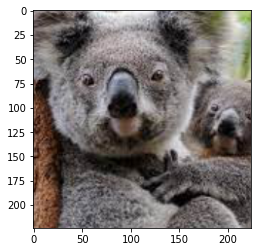

In [10]:
plt.figure()
imshow(image)

#### **사전 학습된(pretrained) 모델을 불러와 사용해보기**

In [11]:
# 입력 데이터 정규화를 위한 클래스 정의
class Normalize(nn.Module) :
    def __init__(self, mean, std) : # 클래스 안에서 사용할 멤버변수를 정의
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        ##.reshape(차원)
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [12]:
# nn.Sequential을 사용한 신경망 구현
model = nn.Sequential(
    # 기본적인 ResNet18과 동일한 동작을 위하여 정규화 레이어 추가
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # torch.hub.load() 함수를 통해 미리 학습된 모델을 불러오기
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
).to(device).eval() # 모델을 GPU로 옮기기 및 평가(테스트) 모드로 변경

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [13]:
# 이미지를 실제 모델에 넣어 결과 확인
outputs = model(image)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100

# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스 >")
print(outputs[0].topk(5)[1])
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스 >
tensor([105, 384, 383, 335, 104], device='cuda:0')
인덱스: 105 / 클래스명: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus / 확률: 99.9288%
인덱스: 384 / 클래스명: indri, indris, Indri indri, Indri brevicaudatus / 확률: 0.0323%
인덱스: 383 / 클래스명: Madagascar cat, ring-tailed lemur, Lemur catta / 확률: 0.0255%
인덱스: 335 / 클래스명: fox squirrel, eastern fox squirrel, Sciurus niger / 확률: 0.0046%
인덱스: 104 / 클래스명: wallaby, brush kangaroo / 확률: 0.0022%
